In [2]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.sql import label
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Design a query to retrieve the last 12 months of precipitation data and plot the results
- Calculate the date 1 year ago from today
- Perform a query to retrieve the data and precipitation scores
- Save the query results as a Pandas DataFrame and set the index to the date column
- Sort the dataframe by date
- Use Pandas Plotting with Matplotlib to plot the data
- Rotate the xticks for the dates

<IPython.core.display.Javascript object>


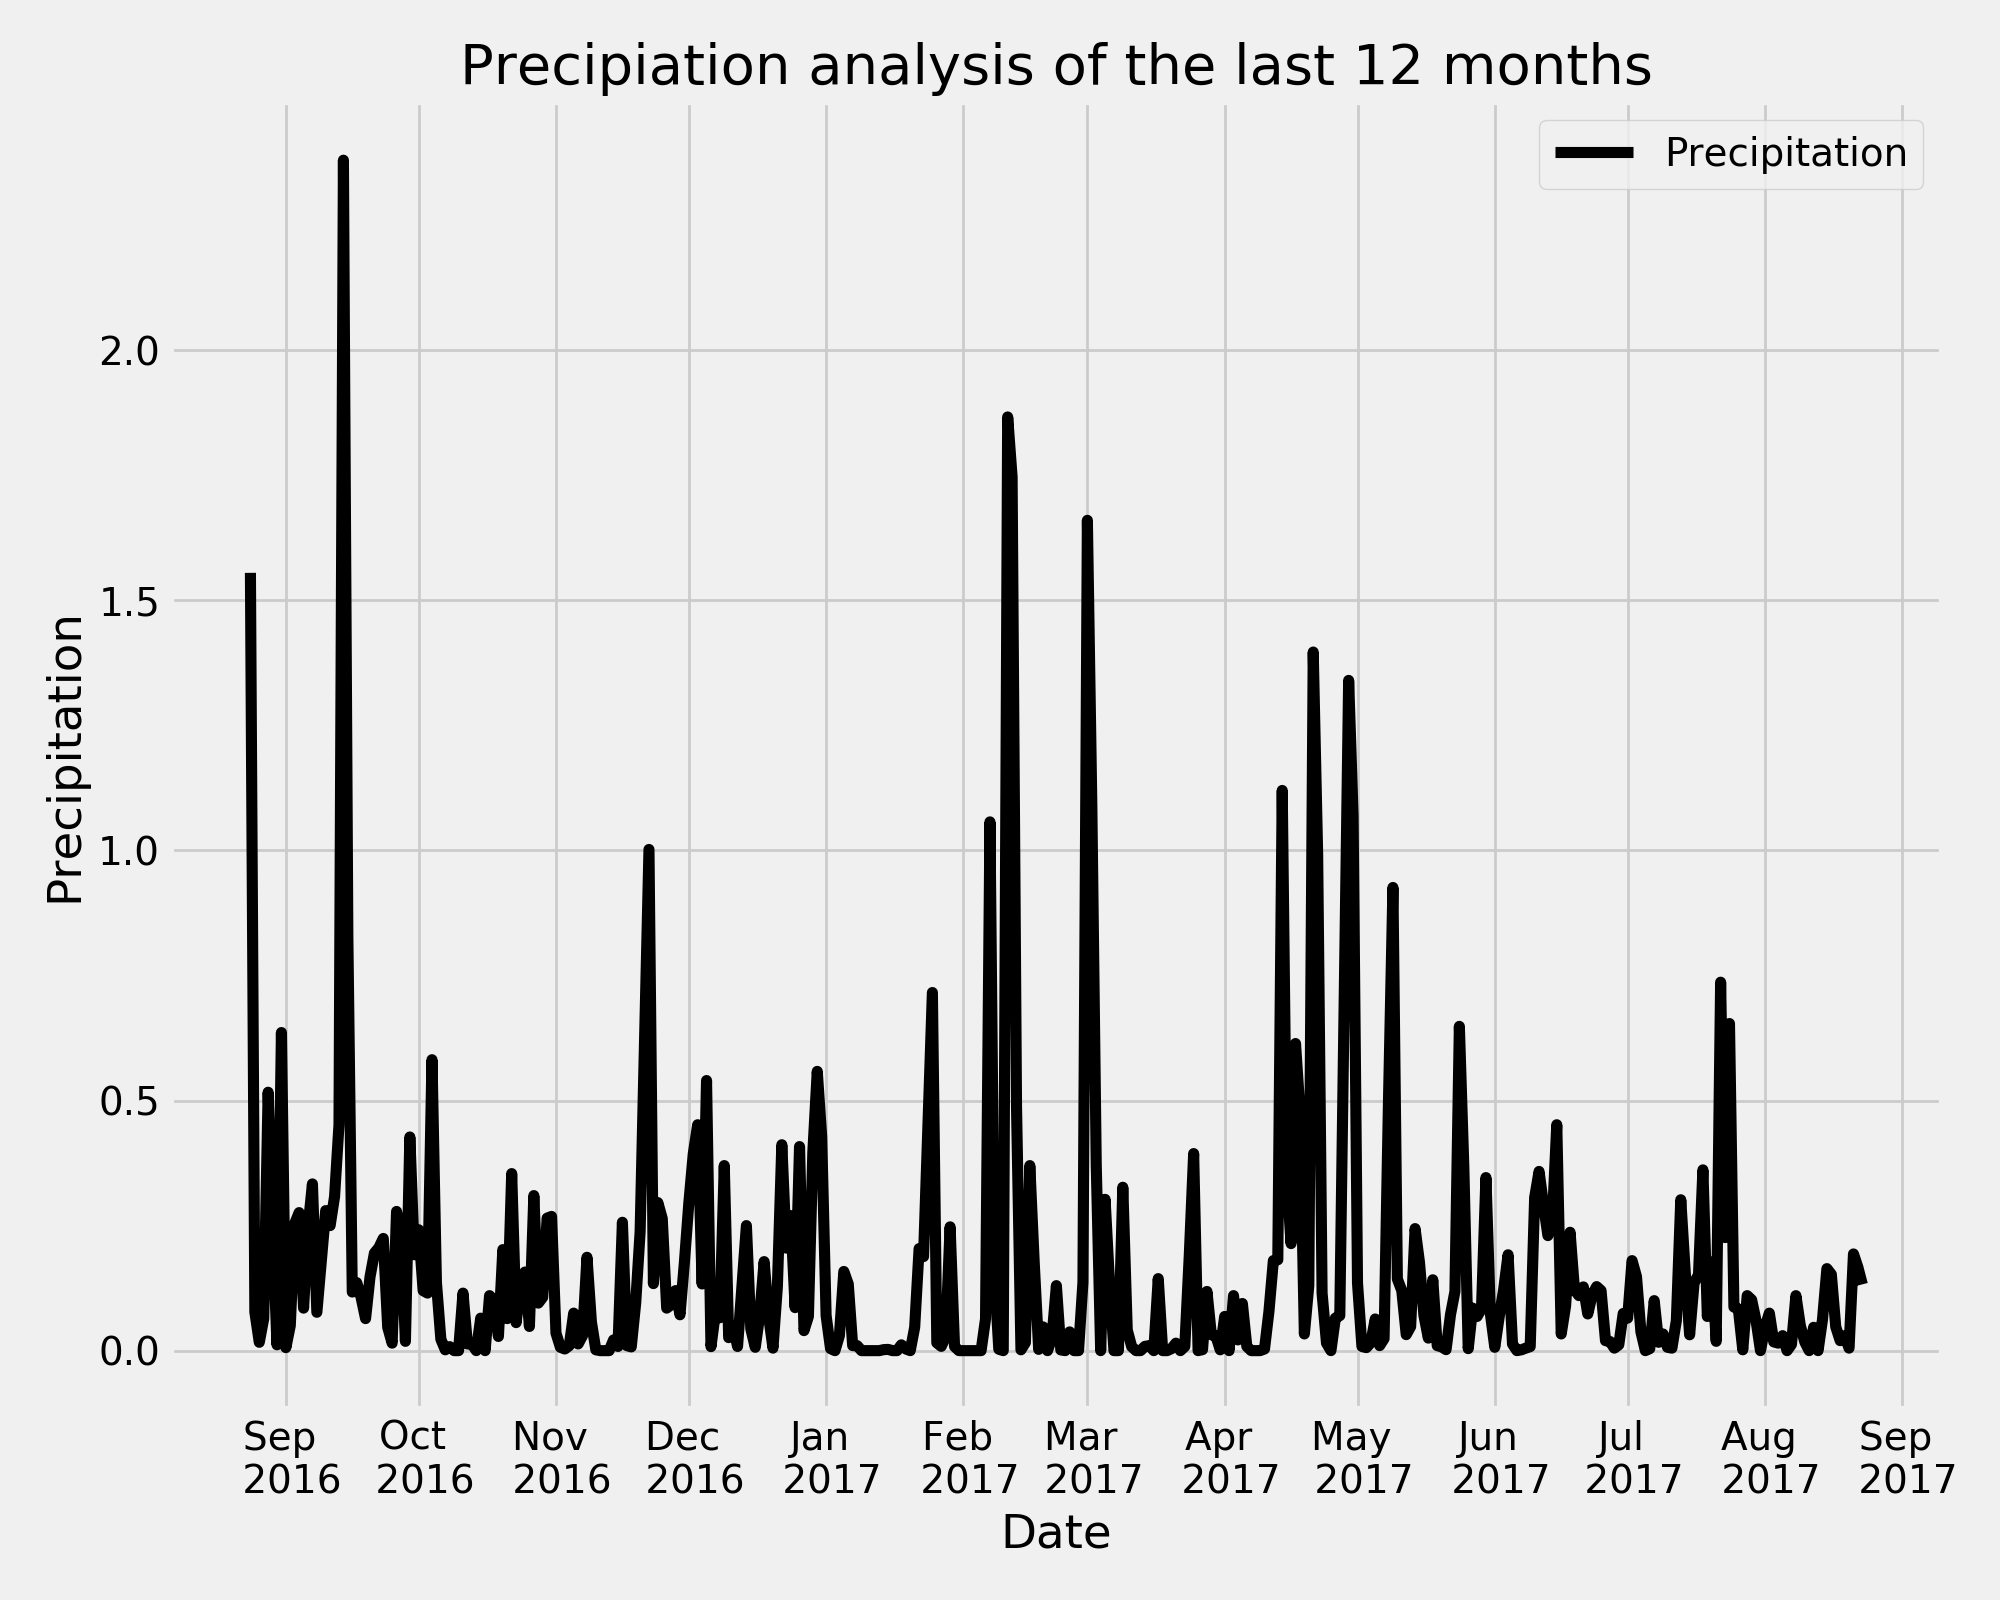

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lastday_string = max(session.query(Measurement.date).all())[0]
lastday = dt.datetime.strptime(lastday_string, '%Y-%m-%d')
one_year_before = lastday - dt.timedelta(days=365)

measurement_record_1year = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).filter(\
    Measurement.date > one_year_before).all()

MDF = pd.DataFrame(measurement_record_1year)
MDF['date'] = pd.to_datetime(MDF['date'], format='%Y-%m-%d')
MDF2 = MDF.groupby('date', as_index=False)[['prcp']].mean()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(MDF2['date'], MDF2['prcp'], color='k')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b \n %Y'))
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation')
ax.legend(["Precipitation"])
ax.set_title('Precipiation analysis of the last 12 months')
plt.savefig("Figures/01_Precipitation_Analysis_last_12_months.png")

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
MDF2.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [13]:
# How many stations are available in this dataset?
total_stations = session.query(Station).distinct().count()
print (f"There are {total_stations} stations in this dataset")

There are 9 stations in this dataset


In [16]:
session.query(Measurement.station,Station.name).distinct().all()

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = session.query(Station.name, Station.station, \
                                label('number_of_observation', func.count(Measurement.id)))\
                                .filter(Measurement.station == Station.station)\
                                .group_by(Station.name, Station.station)\
                                .order_by(func.count(Measurement.id).desc())
                                .all()
ASDF = pd.DataFrame(active_stations)
ASDF

,name,station,number_of_observation
0,"WAIHEE 837.5, HI US",USC00519281,2772
1,"WAIKIKI 717.2, HI US",USC00519397,2724
2,"KANEOHE 838.1, HI US",USC00513117,2709
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2669
4,"MANOA LYON ARBO 785.2, HI US",USC00516128,2612
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,2202
6,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1979
7,"PEARL CITY, HI US",USC00517948,1372
8,"UPPER WAHIAWA 874.3, HI US",USC00518838,511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_freq_station = {'stationid':"",'name':""}
most_freq_station['id'] = ASDF.iloc[:1]['station'][0]
most_freq_station['name'] = ASDF.iloc[:1]['name'][0] 

temperature_record = session.query(Station.name, Station.station,\
                        label('min_temp', func.min(Measurement.tobs)),\
                        label('max_temp', func.max(Measurement.tobs)),\
                        label('avg_temp', func.avg(Measurement.tobs))).\
                        filter(Measurement.station == most_freq_station['id']).all()
TRDF = pd.DataFrame(temperature_record)
TRDF

,name,station,min_temp,max_temp,avg_temp
0,"WAIKIKI 717.2, HI US",USC00519397,54.0,85.0,71.663781


<IPython.core.display.Javascript object>


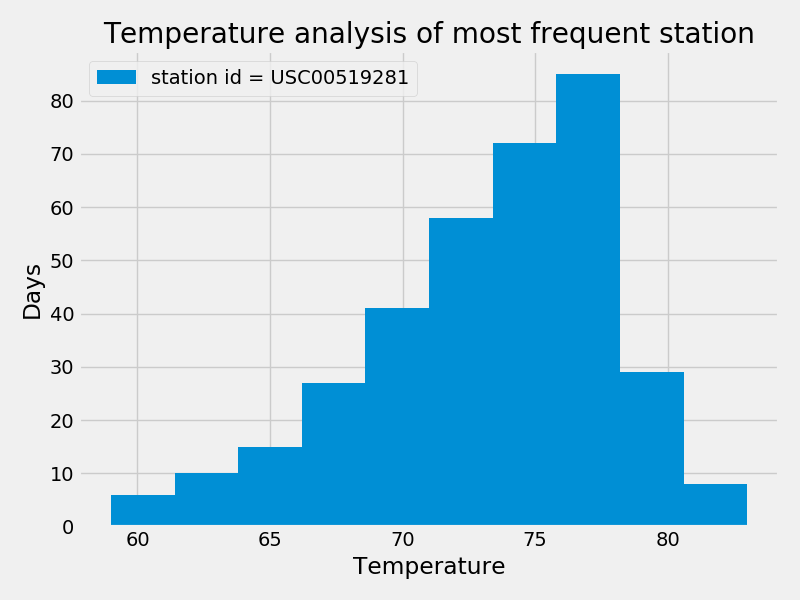

In [15]:
# Choose the station with the highest number of temperature observations.
stations_with_tempobs_frequency = session.query(Station.name, Station.station, \
                                label('number_of_temp_observation', func.count(Measurement.tobs))).\
                                filter(Measurement.station == Station.station).\
                                group_by(Station.name, Station.station).\
                                order_by(func.count(Measurement.tobs).desc()).all()

TFDF = pd.DataFrame(stations_with_tempobs_frequency)

highest_num_tobs_station = {'stationid':"",'name':""}
highest_num_tobs_station['id'] = TFDF.iloc[:1]['station'][0]
highest_num_tobs_station['name'] = TFDF.iloc[:1]['name'][0] 

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
measurement_highest_tobs_record_1year = session.query(Measurement.date, Measurement.tobs).\
                                            filter(Measurement.station == most_freq_station['id']).\
                                            filter(Measurement.date > one_year_before).all()
HTRSDF = pd.DataFrame(measurement_highest_tobs_record_1year)

fig, ax = plt.subplots(figsize=(8,6))
ax.hist(HTRSDF['tobs'])
ax.set_xlabel('Temperature')
ax.set_ylabel('Days')
ax.legend(["station id = " + most_freq_station['id']])
ax.set_title('Temperature analysis of most frequent station')
plt.savefig("Figures/02_Temperature_Analysis_last_12_months_most_frequent_station.png")

In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    import pandas as pd
    startdate_str = start_date
    startdate = dt.datetime.strptime(startdate_str, '%Y-%m-%d')
    enddate_str = end_date
    enddate = dt.datetime.strptime(enddate_str, '%Y-%m-%d')
    
    temp_in_period = session.query(label('min_temp', func.min(Measurement.tobs)),\
                                   label('max_temp', func.max(Measurement.tobs)), \
                                   label('avg_temp', func.avg(Measurement.tobs))).\
                                filter(Measurement.date >= startdate).\
                                filter(Measurement.date <= enddate).all()
    TPDF = pd.DataFrame(temp_in_period)
    TPDF['start_date'] = start_date
    TPDF['end_date'] = end_date
    
    return TPDF

calc_temps('2012-02-28', '2012-03-05')

,min_temp,max_temp,avg_temp,start_date,end_date
0,62.0,74.0,69.4375,2012-02-28,2012-03-05


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def calc_temps_pre1year(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    import pandas as pd
    startdate_str = start_date
    startdate = dt.datetime.strptime(startdate_str, '%Y-%m-%d') - dt.timedelta(days=365)
    enddate_str = end_date
    enddate = dt.datetime.strptime(enddate_str, '%Y-%m-%d') - dt.timedelta(days=365)
    
    temp_in_period = session.query(label('min_temp', func.min(Measurement.tobs)),\
                                   label('max_temp', func.max(Measurement.tobs)), \
                                   label('avg_temp', func.avg(Measurement.tobs))).\
                                filter(Measurement.date >= startdate).\
                                filter(Measurement.date <= enddate).all()
    TPDF = pd.DataFrame(temp_in_period)
    TPDF['trip_start_date'] = start_date
    TPDF['trip_end_date'] = end_date
    TPDF['record_start_date'] = startdate
    TPDF['record_end_date'] = enddate
    
    return TPDF

calc_temps_pre1year('2018-01-05', '2018-01-20')

,min_temp,max_temp,avg_temp,trip_start_date,trip_end_date,record_start_date,record_end_date
0,60.0,81.0,69.913978,2018-01-05,2018-01-20,2017-01-05,2017-01-20


<IPython.core.display.Javascript object>


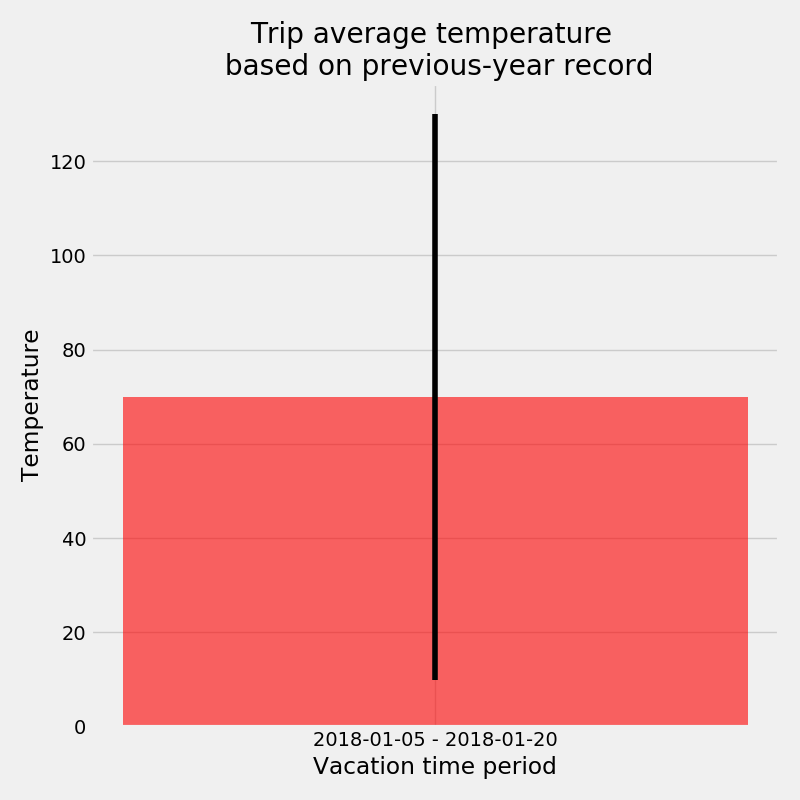

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
def calc_temps_pre1year_plot(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    import pandas as pd
    startdate_str = start_date
    startdate = dt.datetime.strptime(startdate_str, '%Y-%m-%d') - dt.timedelta(days=365)
    enddate_str = end_date
    enddate = dt.datetime.strptime(enddate_str, '%Y-%m-%d') - dt.timedelta(days=365)
    
    temp_in_period = session.query(label('min_temp', func.min(Measurement.tobs)),\
                                   label('max_temp', func.max(Measurement.tobs)), \
                                   label('avg_temp', func.avg(Measurement.tobs))).\
                                filter(Measurement.date >= startdate).\
                                filter(Measurement.date <= enddate).all()
    Max_temp = temp_in_period[0].max_temp
    Min_temp = temp_in_period[0].min_temp
    Avg_temp = temp_in_period[0].avg_temp
    
    year_error = Max_temp = Min_temp
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.bar([1], [Avg_temp], yerr = year_error, color='r', alpha=0.6)
    ax.set_xticks([1])
    ax.set_xticklabels([start_date+' - '+end_date])
    ax.set_xlabel('Vacation time period')
    ax.set_ylabel('Temperature')
    ax.set_title('Trip average temperature \n based on previous-year record')
    plt.show()
    plt.savefig("Figures/03_Trip_Average_Temperature.png")
    
calc_temps_pre1year_plot('2018-01-05', '2018-01-20')

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_rainfall_pre1year(start_date, end_date):

    import pandas as pd
    startdate_str = start_date
    startdate = dt.datetime.strptime(startdate_str, '%Y-%m-%d') - dt.timedelta(days=365)
    enddate_str = end_date
    enddate = dt.datetime.strptime(enddate_str, '%Y-%m-%d') - dt.timedelta(days=365)
    
    prcp_in_period = session.query(Station.name, Station.station,
                                   Station.latitude, Station.longitude, Station.elevation,\
                                   label('avg_rainfall', func.avg(Measurement.prcp))).\
                                filter(Measurement.station == Station.station).\
                                filter(Measurement.date >= startdate).\
                                filter(Measurement.date <= enddate).\
                                group_by(Station.name, Station.station).\
                                order_by(func.avg(Measurement.prcp).desc()).all()

    PSDF = pd.DataFrame(prcp_in_period)
    return PSDF
    
calc_rainfall_pre1year('2018-01-05', '2018-01-20')

,name,station,latitude,longitude,elevation,avg_rainfall
0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,21.52130,-157.83740,7.0,0.056364
1,"MANOA LYON ARBO 785.2, HI US",USC00516128,21.33310,-157.80250,152.4,0.014000
2,"WAIHEE 837.5, HI US",USC00519281,21.45167,-157.84889,32.9,0.008667
3,"KANEOHE 838.1, HI US",USC00513117,21.42340,-157.80150,14.6,0.004000
4,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,21.33556,-157.71139,19.5,0.001250
5,"PEARL CITY, HI US",USC00517948,21.39340,-157.97510,11.9,0.000000
6,"WAIKIKI 717.2, HI US",USC00519397,21.27160,-157.81680,3.0,0.000000


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    import pandas as pd
    # Measurements contains data from 2010/1/1 to 2017/8/23
    date_datetime = dt.datetime.strptime(date, '%m-%d')
    
    
    
    daily_temp = session.query(label('min_temp', func.min(Measurement.tobs)),\
                               label('max_temp', func.max(Measurement.tobs)), \
                               label('avg_temp', func.avg(Measurement.tobs))).\
                                filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
    DTDF = pd.DataFrame(daily_temp)
    DTDF['date'] = date
    DTDF = DTDF.set_index('date')
    return DTDF
    
    
daily_normals("01-01")

,min_temp,max_temp,avg_temp
date,,,
01-01,62.0,77.0,69.153846


In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

def daily_normals_trip(start_date, end_date):

    import pandas as pd
    # Measurements contains data from 2010/1/1 to 2017/8/23
    s = dt.datetime.strptime(start_date, '%m-%d')
    e = dt.datetime.strptime(end_date, '%m-%d')
    p = s
    triplist = []
    while (p <= e):
        triplist.append( p.strftime('%m-%d') )
        p += dt.timedelta(days=1)
        
        
    triplist_temp = []
    for date in triplist:
        daily_temp = session.query(label('min_temp', func.min(Measurement.tobs)),\
                               label('max_temp', func.max(Measurement.tobs)), \
                               label('avg_temp', func.avg(Measurement.tobs))).\
                                filter(func.strftime("%m-%d", Measurement.date) == date).all()
        Max_temp = daily_temp[0].max_temp
        Min_temp = daily_temp[0].min_temp
        Avg_temp = daily_temp[0].avg_temp
        
        triplist_temp.append((Max_temp, Min_temp, Avg_temp))
    
    return triplist, triplist_temp

date_list, normals_list = daily_normals_trip('01-01','01-20')
normals_list 

[(77.0, 62.0, 69.15384615384616),
 (77.0, 60.0, 69.39622641509433),
 (77.0, 62.0, 68.9090909090909),
 (76.0, 58.0, 70.0),
 (76.0, 56.0, 67.96428571428571),
 (76.0, 61.0, 68.96491228070175),
 (76.0, 57.0, 68.54385964912281),
 (75.0, 57.0, 67.16071428571429),
 (78.0, 58.0, 67.9298245614035),
 (77.0, 62.0, 69.74137931034483),
 (78.0, 57.0, 67.3103448275862),
 (81.0, 57.0, 67.4074074074074),
 (77.0, 57.0, 67.25454545454545),
 (77.0, 58.0, 69.52631578947368),
 (78.0, 56.0, 69.31372549019608),
 (80.0, 54.0, 68.62962962962963),
 (76.0, 61.0, 69.07407407407408),
 (77.0, 57.0, 68.63157894736842),
 (78.0, 60.0, 68.26315789473684),
 (78.0, 61.0, 68.86666666666666)]

In [22]:
NMDF = pd.DataFrame(normals_list, columns = ['Max_temp','Min_temp','Avg_temp'], index = date_list)
NMDF.index.name = 'Date'
NMDF

,Max_temp,Min_temp,Avg_temp
Date,,,
01-01,77.0,62.0,69.153846
01-02,77.0,60.0,69.396226
01-03,77.0,62.0,68.909091
01-04,76.0,58.0,70.000000
01-05,76.0,56.0,67.964286
01-06,76.0,61.0,68.964912
01-07,76.0,57.0,68.543860
01-08,75.0,57.0,67.160714
01-09,78.0,58.0,67.929825


<IPython.core.display.Javascript object>


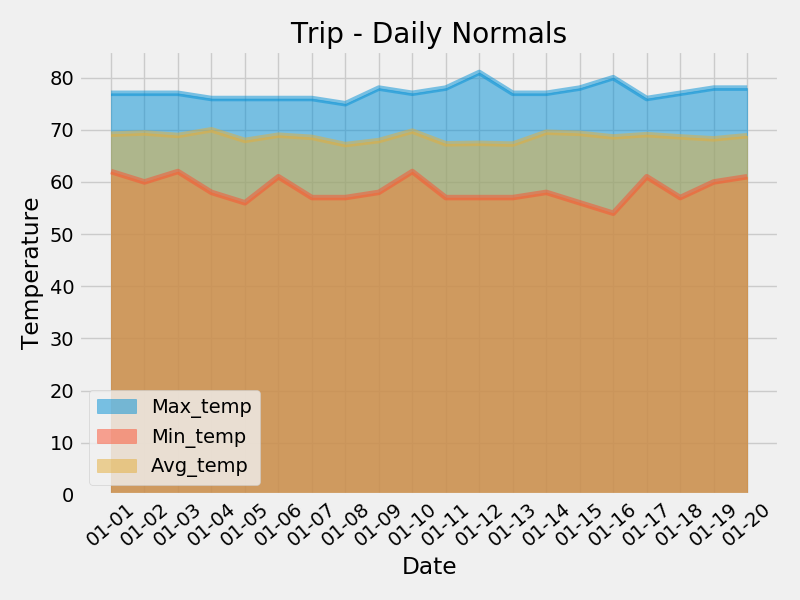

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
NMDF2 = NMDF.reset_index()

fig, ax = plt.subplots(figsize=(8,6))
NMDF2.plot(kind='area', stacked=False, alpha=0.5, ax=ax)
ax.set_xticks(np.arange(0,len(NMDF2)))
ax.set_xticklabels(NMDF2['Date'], rotation=40)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('Trip - Daily Normals')
plt.savefig("Figures/04_Trip_Daily_Normals.png")